In [1]:
import sys
sys.path.append("/home/salmon/workspace/fytok_tutorial/python")

import typing
import numpy as np
from spdm.view import sp_view

from fytok.utils.logger import logger
from fytok.modules.equilibrium import Equilibrium
from fytok.modules.core_transport import CoreTransport, CoreTransportModel
from fytok.modules.core_profiles import CoreProfiles, CoreProfiles1D

2024-07-23 09:02:43,022 [   fytok]  VERBOSE: Using ontology: imas/3 (dummy) at fytok/mappings/{schema}/imas/3:spdm/mapping/{schema}/imas/3


## Equlibrium

In [2]:
eq = Equilibrium("file+geqdsk://./data/geqdsk.txt#equilibrium")

2024-07-23 09:02:43,211 [   fytok]  VERBOSE: Load module fytok.plugins.modules.equilibrium.fy_eq
2024-07-23 09:02:43,214 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_geqdsk


2024-07-23 09:02:43,294 [   fytok]  VERBOSE: Load module spdm.view.view_matplotlib
2024-07-23 09:02:43,315 [   fytok]  VERBOSE: Load module spdm.domain.mesh_rectangular


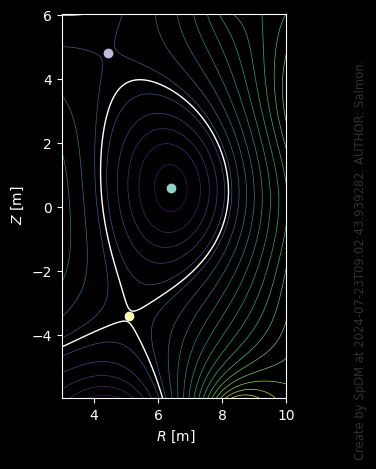

In [3]:
fig=sp_view.display(eq)

In [4]:
eq.profiles_1d.grid.rho_tor_norm

array([0.        , 0.04047789, 0.06552194, 0.08275558, 0.09711053,
       0.10957115, 0.12076599, 0.13101257, 0.14052185, 0.14943398,
       0.15785006, 0.16584504, 0.17347649, 0.18078985, 0.18782157,
       0.19460162, 0.20115478, 0.20750189, 0.21366068, 0.21964631,
       0.22547203, 0.23114951, 0.23668907, 0.24209981, 0.24738993,
       0.25256673, 0.25763679, 0.26260613, 0.2674802 , 0.27226404,
       0.27696228, 0.28157917, 0.28611868, 0.2905845 , 0.29498001,
       0.2993084 , 0.30357262, 0.30777539, 0.31191931, 0.3160068 ,
       0.32004012, 0.32402144, 0.32795278, 0.33183604, 0.33567303,
       0.33946545, 0.34321492, 0.34692299, 0.35059111, 0.3542207 ,
       0.35781312, 0.36136962, 0.36489145, 0.3683798 , 0.3718358 ,
       0.37526053, 0.37865505, 0.38202037, 0.38535745, 0.38866722,
       0.3919506 , 0.39520843, 0.39844156, 0.4016508 , 0.40483697,
       0.40800083, 0.41114316, 0.41426467, 0.41736607, 0.42044804,
       0.42351123, 0.42655627, 0.42958378, 0.43259434, 0.43558

## CoreProfiles

In [5]:
rho_tor_norm = np.linspace(0.01, 0.95, 128)
core_profiles = CoreProfiles(
    vacuum_toroidal_field={"r0": 5.2, "b0": 2.5},
    profiles_1d={
        "grid": eq.profiles_1d.grid.remesh(rho_tor_norm=rho_tor_norm),
        "ion": ["H", "D"],
    },
)
profiles_1d = core_profiles.profiles_1d

In [6]:
profiles_1d.grid.primary_coordinate

'rho_tor_norm'

In [7]:
from spdm.core.expression import _x

In [8]:
profiles_1d.zeff = np.random.random(128)
profiles_1d.electrons.density = np.sqrt(_x) * 1.0e19
profiles_1d.electrons.temperature = (_x**2) * 1.0e5
profiles_1d.ion["H"].density = np.sqrt(_x) * 1.0e19
profiles_1d.ion["H"].temperature = (_x**2) * 1.0e5

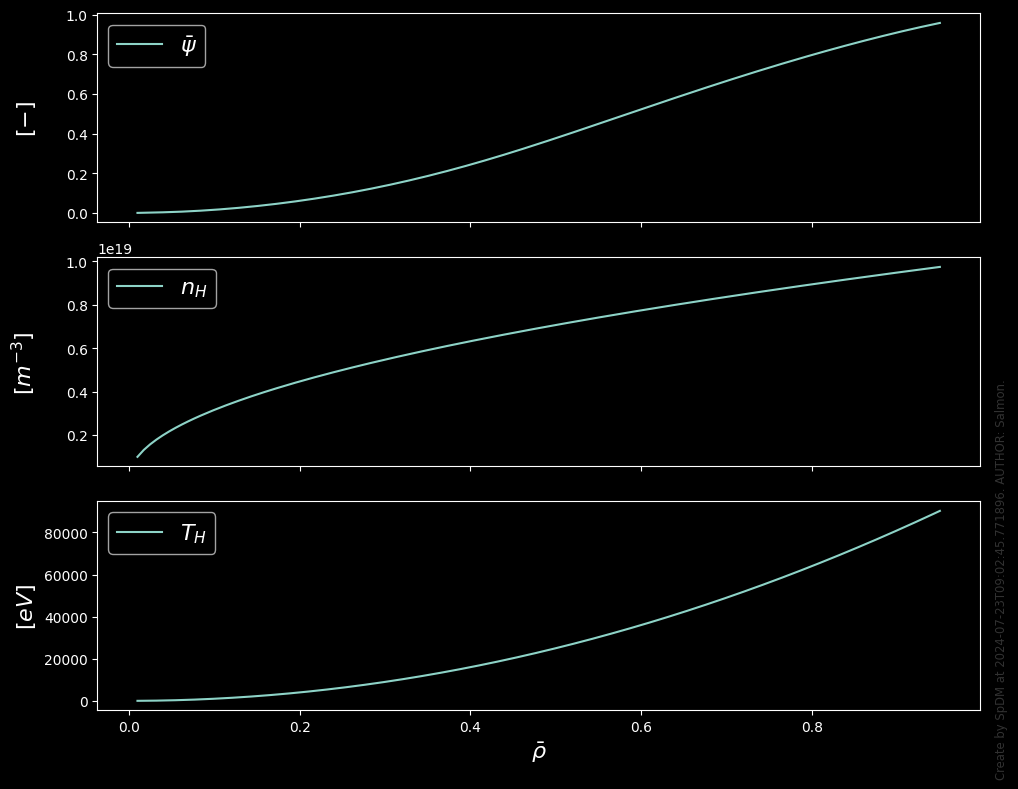

In [9]:
fig = sp_view.plot(
    (profiles_1d.grid.rho_tor_norm, r"$\bar{\rho}$"),
    (profiles_1d.grid.psi_norm,r"$\bar{\psi}$"),
    (profiles_1d.ion["H"].density, r"$n_H$"),
    (profiles_1d.ion["H"].temperature, r"$T_H$"),
)

## 模块调用

In [10]:
class CoreTransportDemo(CoreTransportModel, code={"name": "demo"}):
    """Plugin Demo: CoreTransportModel"""

    def execute(
        self, *args, equilibrium: Equilibrium, core_profiles: CoreProfiles, **kwargs
    ) -> typing.Self:
        res = super().execute(
            *args,
            equilibrium=equilibrium,
            core_profiles=core_profiles,
            **kwargs,
        )
        res_1d: CoreProfiles.Profiles1D = res.profiles_1d
        eq_1d: Equilibrium.Profiles1D = equilibrium.profiles_1d
        prof_1d: CoreProfiles.Profiles1D = core_profiles.profiles_1d
        psi_norm = res_1d.grid.psi_norm
        rho_tor_norm = res_1d.grid.rho_tor_norm

        res.profiles_1d.conductivity_parallel = np.sin(rho_tor_norm * 6.28)
        return res


spitzer = CoreTransportDemo()

In [11]:
spitzer.refresh(equilibrium=eq, core_profiles=core_profiles)

In [12]:
spitzer.profiles_1d.rho_tor_norm

$\bar{\rho}_{tor}$

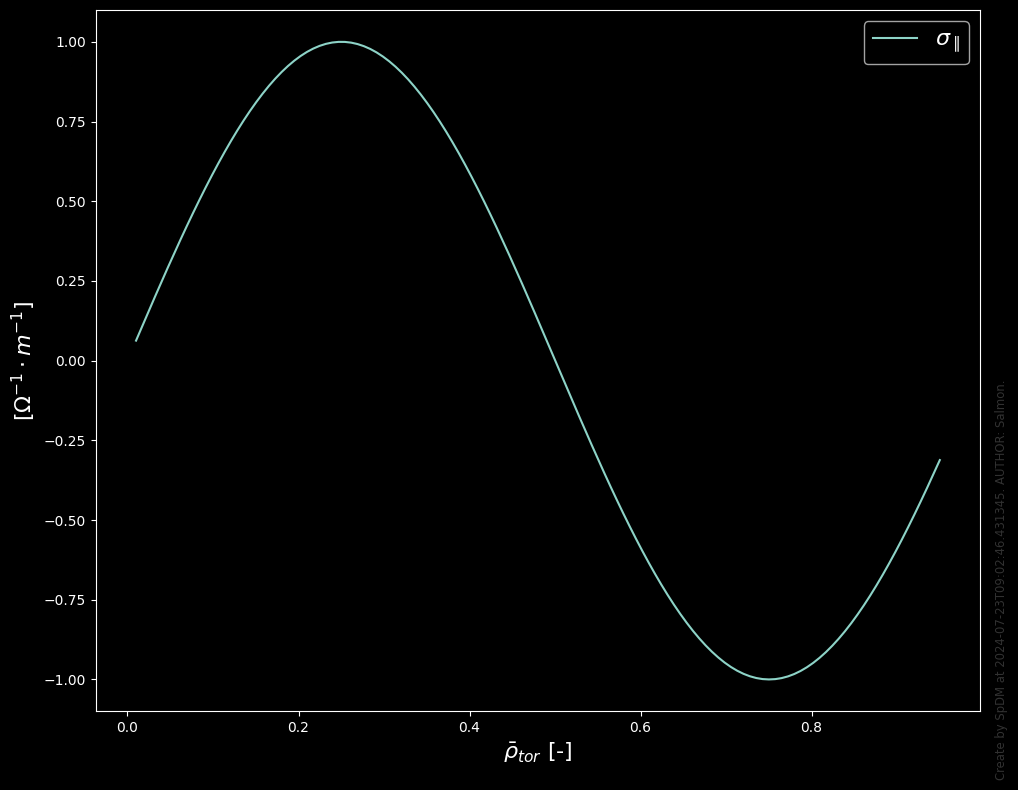

In [13]:
fig=sp_view.plot(spitzer.profiles_1d.rho_tor_norm,spitzer.profiles_1d.conductivity_parallel)

## 插件

In [14]:
model = CoreTransportModel(code={"name": "spitzer_demo"})

2024-07-23 09:02:46,619 [   fytok]  VERBOSE: Load module fytok.plugins.modules.core_transport.model.spitzer_demo


In [16]:
model.refresh(equilibrium=eq, core_profiles=core_profiles)

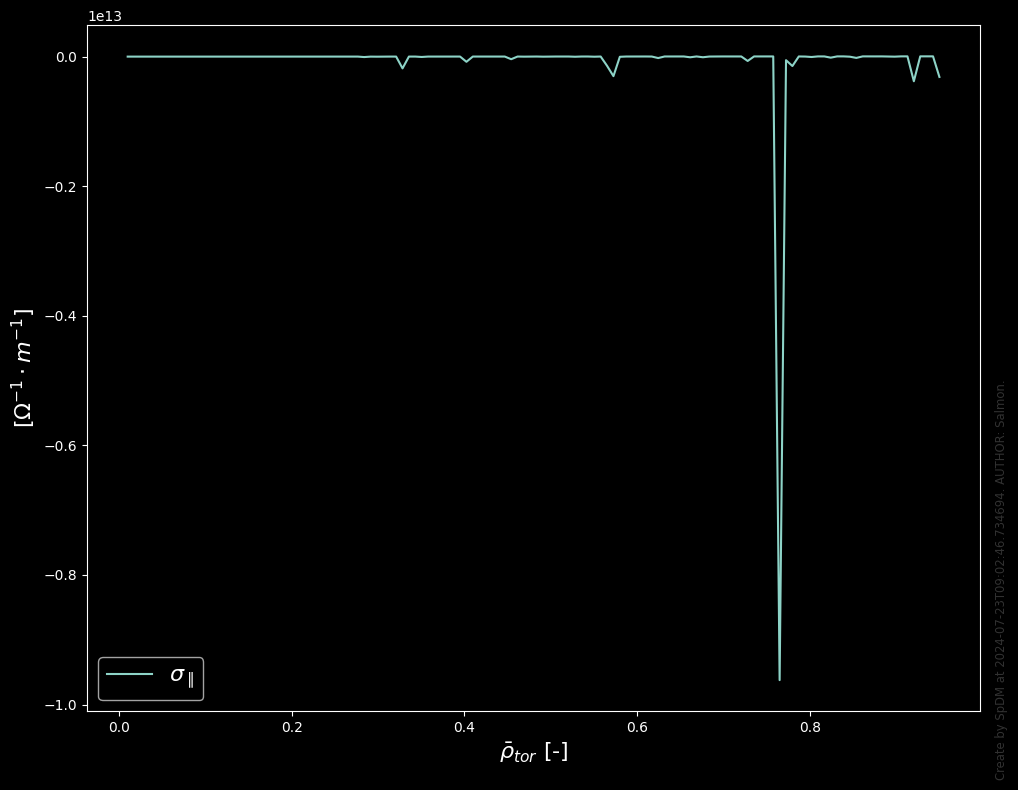

In [17]:
fig=sp_view.plot(model.profiles_1d.rho_tor_norm, model.profiles_1d.conductivity_parallel)